<a href="https://colab.research.google.com/github/Hanifahmed/wind_analysis_project/blob/main/notebooks/wind_analysis_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================
# CELL 0: Mount Drive & Import Libraries
# ==============================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


Mounted at /content/drive


In [2]:
# ==============================
# CELL 1: Load ERA5 Wind Capacity Factor Data
# ==============================

filename = "/content/drive/MyDrive/H_ERA5_ECMW_T639_WON_NA---_Pecd_NUT0_S202401010000_E202412312300_CFR_TIM_01h_COM_noc_org_30_NA---_ReGrB_PhM04_PECD4.2_fv1.csv"

df = pd.read_csv(filename, skiprows=52)
print("Available columns:", df.columns.tolist()[:20])


Available columns: ['Date', 'AL', 'AT', 'BA', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'DZ', 'EE', 'EG', 'EH', 'EL', 'ES', 'FI', 'FR', 'HR']


In [3]:
# ==============================
# CELL 2: Country Data Preparation Function
# ==============================

def prepare_country_data(df, country_code):
    data = df[['Date', country_code]].copy()
    data['Date'] = pd.to_datetime(data['Date'])
    data[country_code] = pd.to_numeric(data[country_code], errors='coerce')
    data.set_index('Date', inplace=True)
    return data


In [4]:
# ==============================
# CELL 3: Prepare Country Datasets (DE, DK, NL)
# ==============================

de_data = prepare_country_data(df, 'DE')
dk_data = prepare_country_data(df, 'DK')
nl_data = prepare_country_data(df, 'NL')

print(de_data.head())
print(dk_data.head())
print(nl_data.head())


                           DE
Date                         
2024-01-01 00:00:00  0.539214
2024-01-01 01:00:00  0.538790
2024-01-01 02:00:00  0.550896
2024-01-01 03:00:00  0.558274
2024-01-01 04:00:00  0.549890
                           DK
Date                         
2024-01-01 00:00:00  0.297519
2024-01-01 01:00:00  0.272151
2024-01-01 02:00:00  0.269957
2024-01-01 03:00:00  0.277264
2024-01-01 04:00:00  0.296639
                           NL
Date                         
2024-01-01 00:00:00  0.819008
2024-01-01 01:00:00  0.819240
2024-01-01 02:00:00  0.827345
2024-01-01 03:00:00  0.821338
2024-01-01 04:00:00  0.789678


Number of low-wind hours: 876
Number of high-wind hours: 879


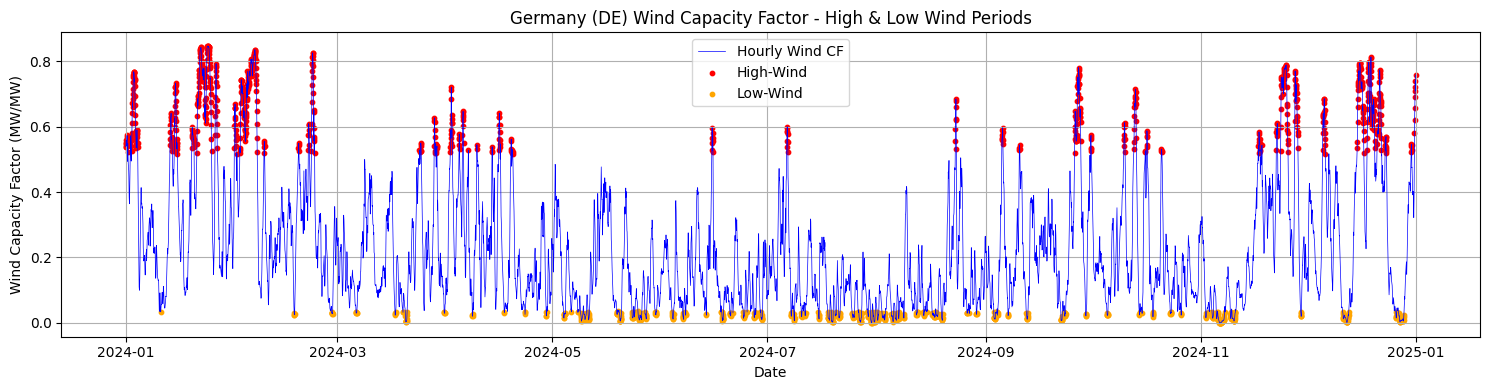

In [ ]:
# ==============================
# CELL 4: Hourly Wind Capacity Factor (Single Country)
# ==============================

def plot_hourly_cf(data, country):
    plt.figure(figsize=(15,4))
    plt.plot(data.index, data[country], linewidth=0.5)
    plt.title(f"{country} Wind Capacity Factor – Hourly (2024)")
    plt.xlabel("Date")
    plt.ylabel("Capacity Factor")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_hourly_cf(de_data, 'DE')


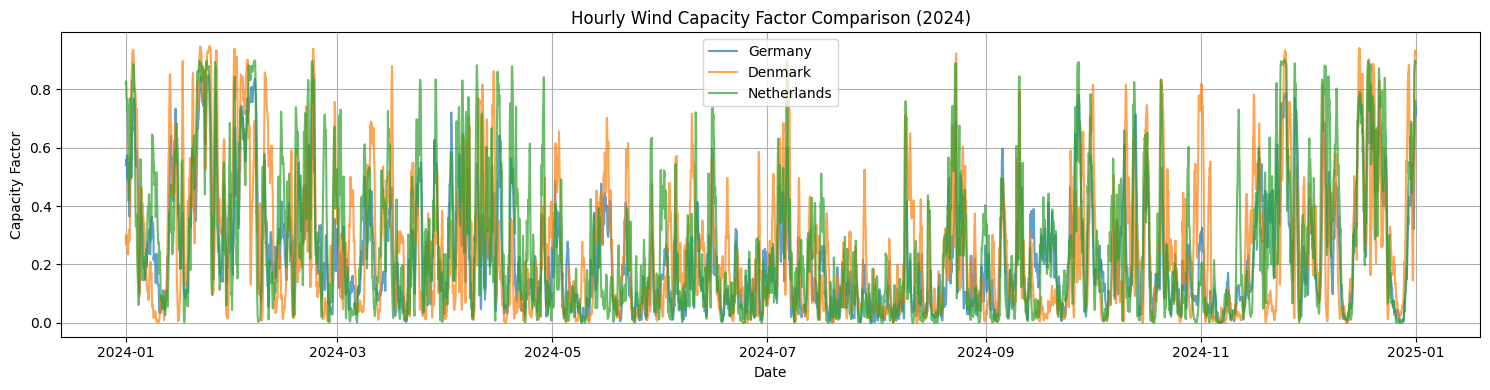

In [5]:
# ==============================
# CELL 5: Hourly Wind CF Comparison (DE, DK, NL)
# ==============================

plt.figure(figsize=(15,4))
plt.plot(de_data['DE'], label='Germany', alpha=0.7)
plt.plot(dk_data['DK'], label='Denmark', alpha=0.7)
plt.plot(nl_data['NL'], label='Netherlands', alpha=0.7)

plt.title("Hourly Wind Capacity Factor Comparison (2024)")
plt.xlabel("Date")
plt.ylabel("Capacity Factor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-81963198.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Monthly": series.resample('M').mean()


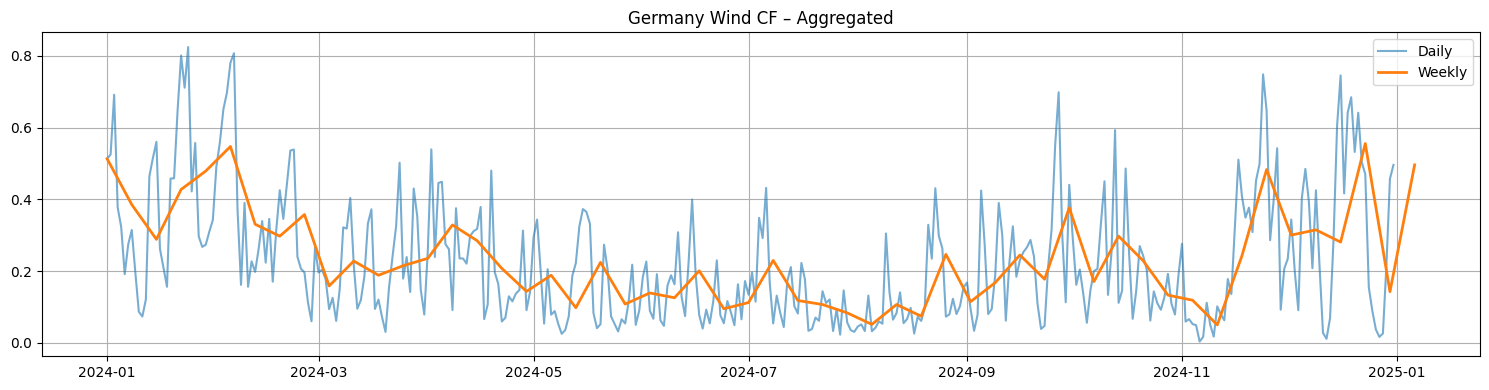

In [6]:
# ==============================
# CELL 6: Aggregated Wind Capacity Factor
# ==============================

def aggregate_cf(series):
    return {
        "Daily": series.resample('D').mean(),
        "Weekly": series.resample('W-MON').mean(),
        "Monthly": series.resample('M').mean()
    }

de_agg = aggregate_cf(de_data['DE'])

plt.figure(figsize=(15,4))
plt.plot(de_agg['Daily'], label='Daily', alpha=0.6)
plt.plot(de_agg['Weekly'], label='Weekly', linewidth=2)
plt.legend()
plt.title("Germany Wind CF – Aggregated")
plt.grid(True)
plt.tight_layout()
plt.show()


count    8784.000000
mean        0.228840
std         0.192717
min         0.000061
25%         0.079257
50%         0.168795
75%         0.332030
max         0.845906
Name: DE, dtype: float64


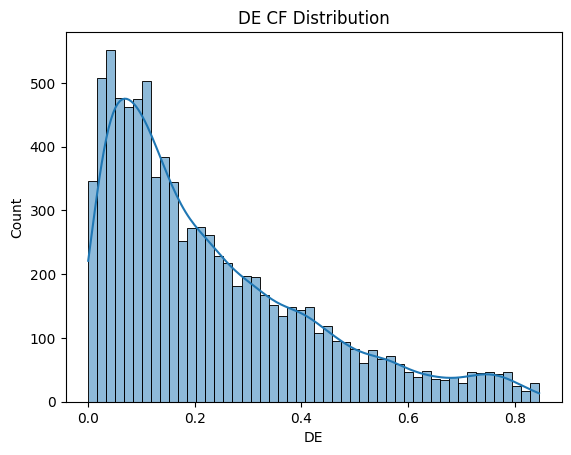

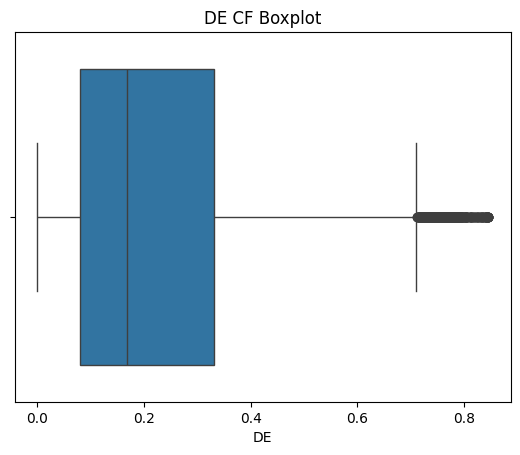

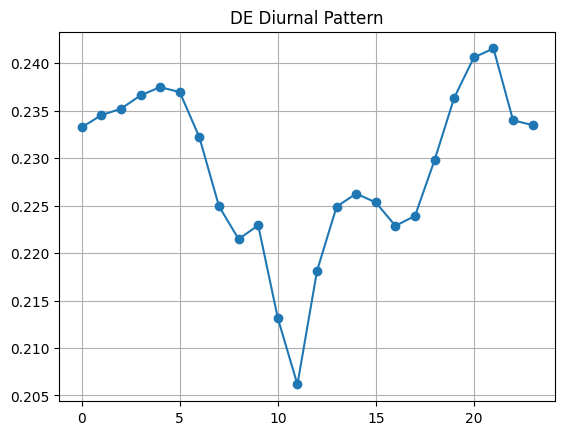

In [7]:
# ==============================
# CELL 7: Distribution & Diurnal Patterns
# ==============================

def distribution_analysis(data, country):
    print(data[country].describe())

    sns.histplot(data[country], bins=50, kde=True)
    plt.title(f"{country} CF Distribution")
    plt.show()

    sns.boxplot(x=data[country])
    plt.title(f"{country} CF Boxplot")
    plt.show()

    hourly = data[country].groupby(data.index.hour).mean()
    plt.plot(hourly, marker='o')
    plt.title(f"{country} Diurnal Pattern")
    plt.grid(True)
    plt.show()

distribution_analysis(de_data, 'DE')


In [8]:
# ==============================
# CELL 8: Extreme Wind Analysis
# ==============================

def extreme_wind_stats(data, country, low=0.035, high=0.517):
    s = data[country]
    low_flag = s <= low
    high_flag = s >= high

    def max_consecutive(flag):
        groups = (flag != flag.shift()).cumsum()
        return flag.groupby(groups).sum().max()

    return {
        "Low_Wind_Hours": low_flag.sum(),
        "High_Wind_Hours": high_flag.sum(),
        "Max_Consec_Low": max_consecutive(low_flag),
        "Max_Consec_High": max_consecutive(high_flag)
    }

extreme_summary = pd.DataFrame({
    "DE": extreme_wind_stats(de_data, 'DE'),
    "DK": extreme_wind_stats(dk_data, 'DK'),
    "NL": extreme_wind_stats(nl_data, 'NL')
}).T

print(extreme_summary)


    Low_Wind_Hours  High_Wind_Hours  Max_Consec_Low  Max_Consec_High
DE             876              879              47              119
DK            1220             1322              63              110
NL            1317             1478              62               71


In [9]:
# ==============================
# CELL 9: Reliability Analysis
# ==============================

def reliability_analysis(series, thresholds):
    results = []
    for thr in thresholds:
        prob_above = (series >= thr).mean()
        flag = series < thr
        groups = (flag != flag.shift()).cumsum()
        max_consec = flag.groupby(groups).sum().max()
        results.append([thr, prob_above, max_consec])
    return pd.DataFrame(results, columns=["Threshold", "P(Wind ≥ Thr)", "Max_Consec_Below"])

thresholds = [0.1, 0.2, 0.3, 0.4]
print(reliability_analysis(de_data['DE'], thresholds))


   Threshold  P(Wind ≥ Thr)  Max_Consec_Below
0        0.1       0.683288               109
1        0.2       0.444900               295
2        0.3       0.289390               642
3        0.4       0.183402               800


In [10]:
# ==============================
# CELL 10: Hub-Height Wind Speed Extrapolation
# ==============================

z_ref = 100
z_hub = 120
alpha = 0.14

de_data['U_ref'] = de_data['DE'] * 12
de_data['U_hub'] = de_data['U_ref'] * (z_hub / z_ref) ** alpha

print(de_data[['U_ref', 'U_hub']].head())


                        U_ref     U_hub
Date                                   
2024-01-01 00:00:00  6.470565  6.637852
2024-01-01 01:00:00  6.465475  6.632631
2024-01-01 02:00:00  6.610753  6.781665
2024-01-01 03:00:00  6.699287  6.872487
2024-01-01 04:00:00  6.598684  6.769284


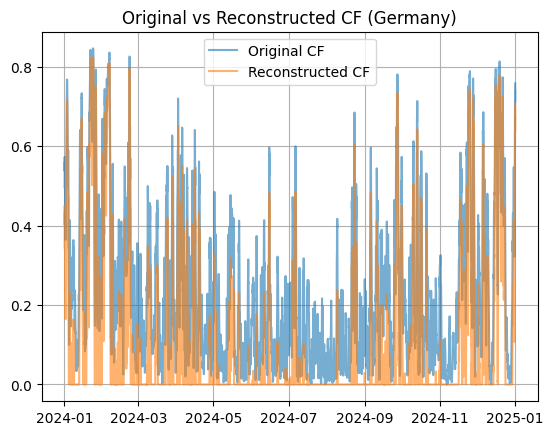

In [11]:
# ==============================
# CELL 11: Turbine Power Curve & CF Reconstruction
# ==============================

def turbine_power(u):
    if u < 3:
        return 0
    elif u < 12:
        return (u - 3) / 9
    elif u <= 25:
        return 1
    else:
        return 0

de_data['CF_reconstructed'] = de_data['U_hub'].apply(turbine_power)

plt.plot(de_data['DE'], label='Original CF', alpha=0.6)
plt.plot(de_data['CF_reconstructed'], label='Reconstructed CF', alpha=0.6)
plt.legend()
plt.title("Original vs Reconstructed CF (Germany)")
plt.grid(True)
plt.show()


In [12]:
# ==============================
# CELL 12: ERA5 Validation Metrics (Conceptual)
# ==============================

de_data['U_obs'] = de_data['U_hub'] + np.random.normal(0, 1, len(de_data))

bias = (de_data['U_hub'] - de_data['U_obs']).mean()
rmse = np.sqrt(((de_data['U_hub'] - de_data['U_obs'])**2).mean())
corr = de_data[['U_hub', 'U_obs']].corr().iloc[0,1]

print(f"Bias: {bias:.2f} m/s")
print(f"RMSE: {rmse:.2f} m/s")
print(f"Correlation: {corr:.2f}")


Bias: -0.01 m/s
RMSE: 1.00 m/s
Correlation: 0.92


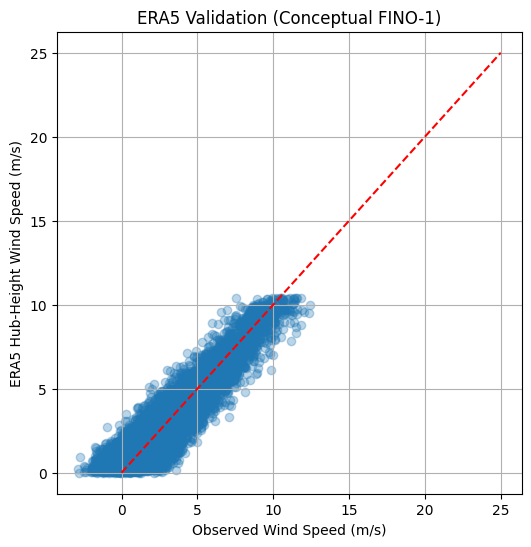

In [13]:
# ==============================
# CELL 13: ERA5 vs Observation Comparison
# ==============================

plt.figure(figsize=(6,6))
plt.scatter(de_data['U_obs'], de_data['U_hub'], alpha=0.3)
plt.plot([0,25],[0,25],'r--')
plt.xlabel("Observed Wind Speed (m/s)")
plt.ylabel("ERA5 Hub-Height Wind Speed (m/s)")
plt.title("ERA5 Validation (Conceptual FINO-1)")
plt.grid(True)
plt.show()


In [14]:
# ==============================
# CELL 14: Capacity Factor & Annual Energy Production
# ==============================

P_rated = 3000  # kW
de_data['Power_kW'] = de_data['CF_reconstructed'] * P_rated

CF_annual = de_data['CF_reconstructed'].mean()
AEP = de_data['Power_kW'].sum() / 1000

print(f"Annual Capacity Factor: {CF_annual:.2%}")
print(f"Annual Energy Production: {AEP:,.0f} MWh")


Annual Capacity Factor: 9.78%
Annual Energy Production: 2,577 MWh
